In [1347]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [1477]:
with open('./output.txt','r') as f:
    res = pd.read_csv(f, delimiter=' ', header=None,names=['n','p','frac','stddev'])
    
#res = res[res['frac']<0.90]
data = res[['n','p','frac']].values
n_mean, p_mean = res.mean()[['n','p']]
n_std, p_std = res.std()[['n','p']]
def conv(x):
    x[:,0] = (x[:,0]-n_mean)/n_std
    x[:,1] = (x[:,1]-p_mean)/p_std
    return x

def conv_y(y, cls_sz):
    y = np.asarray(y)
    return (y * cls_sz).astype(np.int), (y - (y*cls_sz).astype(np.int)/cls_sz)*cls_sz

In [1555]:
class Net(nn.Module):
    def __init__(self, ft_sz, cls_sz):
        super(Net, self).__init__()
        self.ft_sz = ft_sz
        self.cls_sz = cls_sz
#        self.fc = nn.Sequential( nn.Linear(2, ft_sz), nn.BatchNorm1d(ft_sz), nn.ReLU())
        self.fc = nn.Sequential( nn.Linear(2, ft_sz), nn.ReLU(), nn.BatchNorm1d(ft_sz),\
                                nn.Linear(ft_sz,2*ft_sz), nn.ReLU(), nn.BatchNorm1d(2*ft_sz),\
                                nn.Linear(2*ft_sz, ft_sz), nn.ReLU())
        self.head1 = nn.Linear(ft_sz, cls_sz)
        self.head2 = nn.Linear(ft_sz, 1)
    
    def forward(self,x):
        x = self.fc(x)
        return (self.head1(x), self.head2(x))
    
    

In [1629]:
lr = 1e-4
ft_sz = 32
cls_sz = 100
#net = nn.Sequential( nn.Linear(2, ft_sz), nn.ReLU(), nn.Linear(ft_sz, 2*ft_sz), nn.ReLU(),\
#                    nn.BatchNorm1d(2*ft_sz), nn.Linear(2*ft_sz, ft_sz),\
#                    nn.ReLU(), nn.Linear(ft_sz,1) )
#net = nn.Sequential(nn.Linear(2,ft_sz), nn.ReLU(), nn.Linear(ft_sz, 10))
net = Net( ft_sz=ft_sz, cls_sz=cls_sz)
net.cuda()
#optm = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=0.99, nesterov=True, momentum=0.1)
optm = torch.optim.Adam(net.parameters(), lr=lr)
crit1 = torch.nn.CrossEntropyLoss()
crit2 = torch.nn.SmoothL1Loss()

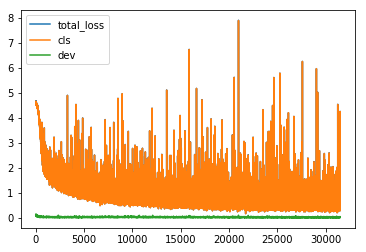

In [1630]:
epoch = 500
bsz   = 32
loss_1 = []
loss_2 = []
train_loss = []
for e in range(epoch):
    np.random.shuffle(data)
    for d in range(0, len(data), bsz):
        d = data[d:min(d+bsz,len(data))].copy()
        x, y = d[:,:2], d[:,-1]
        x = conv(x)
        y = conv_y(y, cls_sz)
        optm.zero_grad()
        x = torch.Tensor(x).cuda()
        y_cls = torch.Tensor(y[0]).long().cuda()
        y_dev = torch.Tensor(y[1]).cuda()
        pred = net(x)
        loss1 = crit1(pred[0], y_cls)
        loss2 = crit2(pred[1], y_dev.unsqueeze(-1))
        loss = loss1 + 0.1*loss2
        loss_1.append(loss1.item())
        loss_2.append(loss2.item())
        train_loss.append(loss.item())
        loss.backward()
        optm.step()
        
plt.plot(train_loss, label='total_loss')
plt.plot(loss_1, label='cls')
plt.plot(loss_2, label='dev')
plt.legend()

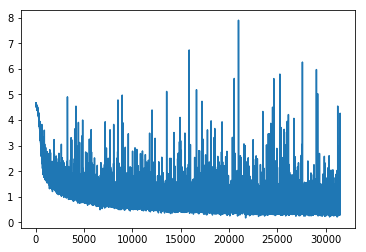

In [1631]:
plt.plot(loss_1)

In [1632]:
## eval
bsz   = 512
train_loss = []
truth = []
preds = []
losses = []
for d in range(0, len(data), bsz):
    d = data[d:min(d+bsz,len(data))].copy()
    x, y = d[:,:2], d[:,-1]
    truth.extend(y)
    x = conv(x)
    y = conv_y(y, cls_sz)
    x = torch.Tensor(x).cuda()
    y_cls = torch.Tensor(y[0]).long().cuda()
    y_dev = torch.Tensor(y[1]).cuda()
    pred = net(x)
    preds.extend((pred[0].argmax(1).float()/cls_sz + 1/cls_sz*pred[1].squeeze()).cpu().detach().numpy())
    losses.append(loss.item())

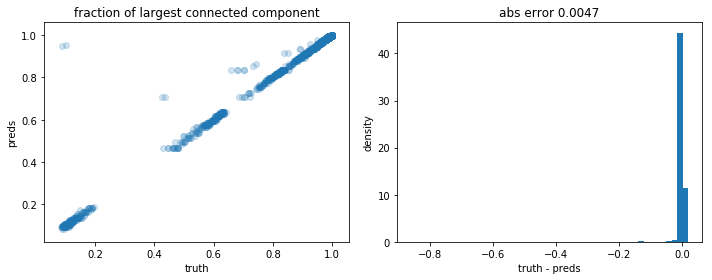

In [1650]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0]
axes[0].scatter(truth,preds, alpha=0.2, marker='o')
axes[0].set_xlabel('truth')
axes[0].set_ylabel('preds')
axes[0].set_title('fraction of largest connected component')
axes[1].hist(np.asarray(truth)-np.asarray(preds), 50, density=True)
axes[1].set_xlabel('truth - preds')
axes[1].set_ylabel('density')
axes[1].set_title('abs error {:1.4f}'.format(np.mean(np.abs(np.asarray(truth)-np.asarray(preds)))))
fig.tight_layout()
fig.savefig('./surrogate_error.png', dpi=300, bbox_inches='tight')

## Regression Model

In [1606]:
lr = 1e-4
ft_sz = 32
net = nn.Sequential( nn.Linear(2, ft_sz), nn.ReLU(), nn.BatchNorm1d(ft_sz), \
                    nn.Linear(ft_sz, 2*ft_sz), nn.ReLU(), nn.BatchNorm1d(2*ft_sz),\
                    nn.Linear(2*ft_sz, ft_sz), nn.ReLU(), nn.Linear(ft_sz,1) )
#net = nn.Sequential( nn.Linear(2, ft_sz), nn.BatchNorm1d(ft_sz), nn.ReLU(), \
#                    nn.Linear(ft_sz, 2*ft_sz), nn.BatchNorm1d(2*ft_sz), nn.ReLU(),\
#                    nn.Linear(2*ft_sz, ft_sz), nn.ReLU(), nn.Linear(ft_sz,1) )
#net = nn.Sequential(nn.Linear(2,ft_sz), nn.ReLU(), nn.BatchNorm1d(ft_sz), nn.Linear(ft_sz, 1))
net.cuda()
#optm = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=0.99, nesterov=True, momentum=0.01)
#optm = torch.optim.SGD(net.parameters(), lr=lr)
optm = torch.optim.Adam(net.parameters(), lr=lr)
crit = torch.nn.SmoothL1Loss()

In [1607]:
epoch = 1000
bsz   = 32
train_loss = []
for e in range(epoch):
    np.random.shuffle(data)
    for d in range(0, len(data), bsz):
        d = data[d:min(d+bsz,len(data))].copy()
        x, y = d[:,:2], d[:,-1]
        x = conv(x)
        optm.zero_grad()
        x, y = torch.Tensor(x).cuda(), torch.Tensor(y).cuda()
        pred = net(x)
        loss = crit(pred, y.unsqueeze(-1))
        train_loss.append(loss.item())
        loss.backward()
        optm.step()
        

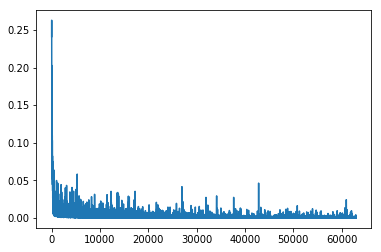

In [1608]:
plt.plot(train_loss)

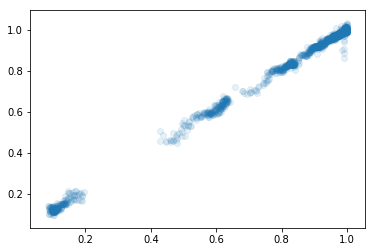

In [1609]:
bsz   = 512
train_loss = []
truth = []
preds = []
losses = []
for d in range(0, len(data), bsz):
    d = data[d:min(d+bsz,len(data))].copy()
    x, y = d[:,:2], d[:,-1]
    x = conv(x)
    optm.zero_grad()
    x, y = torch.Tensor(x).cuda(), torch.Tensor(y).cuda()
    pred = net(x)
    loss = crit(pred, y.unsqueeze(-1))
    truth.extend(y.cpu().detach().numpy())
    preds.extend(pred.squeeze().cpu().detach().numpy())
    losses.append(loss.item())
plt.scatter(truth,preds, alpha=0.1)

0.009201593


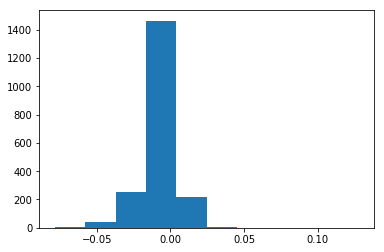

In [1611]:
plt.hist(np.asarray(truth)-np.asarray(preds))
print(np.mean(np.abs(np.asarray(truth)-np.asarray(preds))))

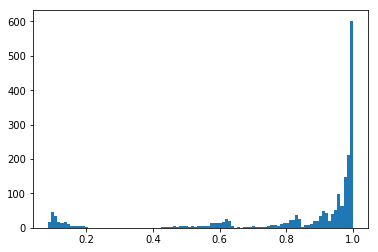

In [1605]:
plt.hist(res['frac'], 100);

In [536]:
res.mean(), res.std()

(n         550.000000
 p           0.008684
 frac        0.841605
 stddev      0.021851
 dtype: float64, n         261.312641
 p           0.006890
 frac        0.259153
 stddev      0.027434
 dtype: float64)

In [538]:
res_norm = (res - res.mean()) / res.std()

(array([ 43.,  30.,  56.,  51.,  67.,  75.,  84.,  90., 105., 116., 127.,
        141., 153., 136., 115.,  98.,  85.,  75.,  64.,  54.,  44.,  40.,
         35.,  29.,  23.,  19.,  14.,  11.,   7.,   4.]),
 array([-0.95526135, -0.85892123, -0.76258111, -0.66624099, -0.56990087,
        -0.47356075, -0.37722063, -0.28088051, -0.18454039, -0.08820027,
         0.00813985,  0.10447997,  0.20082009,  0.29716021,  0.39350033,
         0.48984044,  0.58618056,  0.68252068,  0.7788608 ,  0.87520092,
         0.97154104,  1.06788116,  1.16422128,  1.2605614 ,  1.35690152,
         1.45324164,  1.54958176,  1.64592188,  1.742262  ,  1.83860212,
         1.93494224]),
 <a list of 30 Patch objects>)

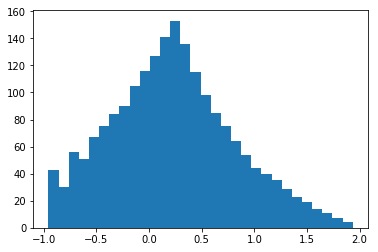

In [551]:
plt.hist(np.log(res_norm['p']+1.5),30)

In [556]:
a,b = res.mean()[['n','p']]

In [557]:
a,b

(550.0, 0.008684073942056942)

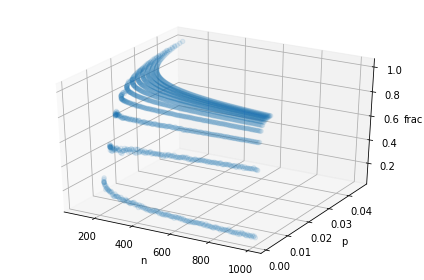

In [1651]:
with open('./output.txt','r') as f:
    res = pd.read_csv(f, delimiter=' ', header=None,names=['n','p','frac','stddev'])
    
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('n')
ax.set_ylabel('p')
ax.set_zlabel('frac')
ax.scatter(res['n'], res['p'], res['frac'], alpha=0.1)
fig.tight_layout()
fig.savefig('./ER_train.png',dpi=300, bbox_inches='tight')